In [ ]:
import os
import cv2
import numpy as np
from config import *
from data_preprocessor import *
from model import *
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
import gc
import psutil
import json

In [ ]:
X_train, X_text, y_train, y_test = read_data()

# Bee Colony Optimisation

### Initialization of Food Sources
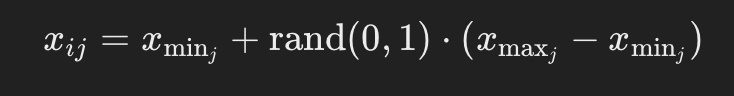


### Generating New Food Source 
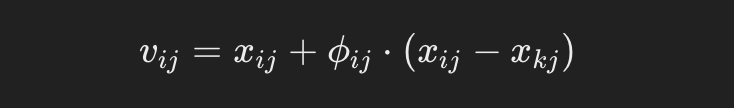

### Greedy Selection
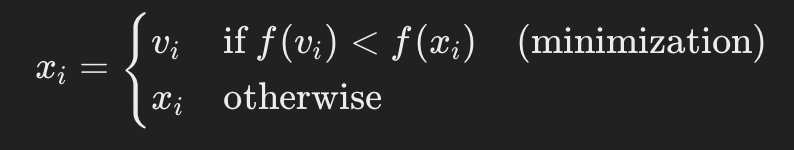

### Probability of Selection by Onlooker Bees
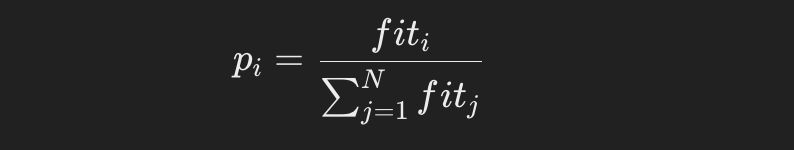

### Scout Bee Behavior
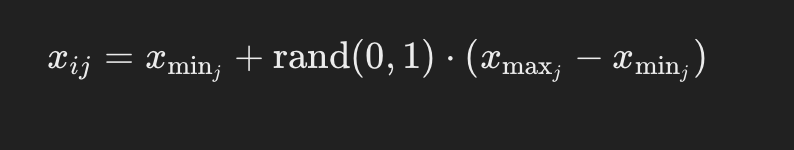

In [ ]:
def save_init_params(params):
    with open("initial_params.json", "w") as file:
        json.dump(params, file, indent = 4)

class BeeColonyOptimization:
    def __init__(self, X_train, y_train, num_bees=6, num_employed=3, num_onlooker=3, num_iterations=4):
        self.train_imgs = X_train
        self.train_labels = y_train
        self.num_bees = num_bees
        self.num_employed = num_employed
        self.num_onlooker = num_onlooker
        self.num_iterations = num_iterations
        self.param_space = {
            'lr': [0.0001, 0.01],
            'batch_size': [16, 64],
            'filters1': [32, 64],
            'filters2': [32, 64],
            'units1': [32, 64],
            'dropout': [0.1, 0.5],
        }
        self.food_sources = [self.random_params() for _ in range(num_employed)]
        self.fitness = np.array([objective_function(p, self.train_imgs, self.train_labels) for p in self.food_sources])

    def random_params(self):
        return {
            'lr': np.random.uniform(*self.param_space['lr']),
            'batch_size': int(np.random.uniform(*self.param_space['batch_size'])),
            'filters1': int(np.random.uniform(*self.param_space['filters1'])),
            'filters2': int(np.random.uniform(*self.param_space['filters2'])),
            'units1': int(np.random.uniform(*self.param_space['units1'])),
            'dropout': np.random.uniform(*self.param_space['dropout']),
        }

    def optimize(self):
        for iter_num in range(self.num_iterations):
            print(f"\n Iteration {iter_num + 1}/{self.num_iterations}")

            # Employed Bee Phase
            for i in range(self.num_employed):
                new_params = self.mutate_params(i)
                new_fitness = objective_function(new_params, self.train_imgs, self.train_labels)
                if new_fitness > self.fitness[i]:
                    print(f"Employed Bee {i} found better solution.")
                    self.food_sources[i] = new_params
                    self.fitness[i] = new_fitness

            # Onlooker Bee Phase
            probabilities = self.calculate_probabilities()
            for i in range(self.num_onlooker):
                selected_index = np.random.choice(range(self.num_employed), p=probabilities)
                new_params = self.mutate_params(selected_index)
                new_fitness = objective_function(new_params, self.train_imgs, self.train_labels)
                if new_fitness > self.fitness[selected_index]:
                    print(f"Onlooker Bee {i} improved solution at index {selected_index}.")
                    self.food_sources[selected_index] = new_params
                    self.fitness[selected_index] = new_fitness

            # Scout Bee Phase
            worst_index = np.argmin(self.fitness)
            print(f"Scout Bee replacing worst solution at index {worst_index}.")
            self.food_sources[worst_index] = self.random_params()
            self.fitness[worst_index] = objective_function(self.food_sources[worst_index], self.train_imgs, self.train_labels)

            best_iter_idx = np.argmin(self.fitness)
            print(f"Best so far: Accuracy = {-self.fitness[best_iter_idx]:.4f}")

        best_index = np.argmax(self.fitness)
        return self.food_sources[best_index], -self.fitness[best_index]

    def mutate_params(self, index):
        new_params = self.food_sources[index].copy()
        for key in self.param_space:
            if np.random.rand() < 0.3:  # 30% chance to mutate each param
                if key in ['filters1', 'filters2', 'units1', 'units2', 'batch_size']:
                    new_params[key] = int(np.random.uniform(*self.param_space[key]))
                else:
                    new_params[key] = np.random.uniform(*self.param_space[key])
        return new_params

    def calculate_probabilities(self):
        fitness_inverse = 1 / (1 + self.fitness)
        return fitness_inverse / np.sum(fitness_inverse)

# Run the Bee Colony Optimization
bco = BeeColonyOptimization(X_train, y_train)
nests = bco.food_sources
print(nests)
save_init_params(nests)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluated Params: {'lr': 0.008789098700666468, 'batch_size': 22, 'filters1': 52, 'filters2': 48, 'units1': 45, 'dropout': 0.23562910689945527}
Validation Accuracy: 0.2656
Memory usage (MB): 3354.78125
Evaluated Params: {'lr': 0.007011921512008315, 'batch_size': 26, 'filters1': 47, 'filters2': 54, 'units1': 48, 'dropout': 0.39452114202640026}
Validation Accuracy: 0.2266
Memory usage (MB): 3617.84375
Evaluated Params: {'lr': 0.00984578875390895, 'batch_size': 56, 'filters1': 49, 'filters2': 51, 'units1': 52, 'dropout': 0.1523667422741935}
Validation Accuracy: 0.2266
Memory usage (MB): 3828.015625
[{'lr': 0.008789098700666468, 'batch_size': 22, 'filters1': 52, 'filters2': 48, 'units1': 45, 'dropout': 0.23562910689945527}, {'lr': 0.007011921512008315, 'batch_size': 26, 'filters1': 47, 'filters2': 54, 'units1': 48, 'dropout': 0.39452114202640026}, {'lr': 0.00984578875390895, 'batch_size': 56, 'filters1': 49, 'filters2': 51, 'units1': 52, 'dropout': 0.1523667422741935}]


In [6]:
best_params, best_accuracy = bco.optimize()
print("\n Best Hyperparameters:", best_params)
print("Best Validation Accuracy:", best_accuracy)
print(nests)


 Iteration 1/4
Evaluated Params: {'lr': 0.008789098700666468, 'batch_size': 22, 'filters1': 52, 'filters2': 48, 'units1': 45, 'dropout': 0.25301054195217443}
Validation Accuracy: 0.2656
Memory usage (MB): 4008.234375
Evaluated Params: {'lr': 0.007011921512008315, 'batch_size': 26, 'filters1': 47, 'filters2': 54, 'units1': 48, 'dropout': 0.4597438470398815}
Validation Accuracy: 0.2266
Memory usage (MB): 4142.71875
Evaluated Params: {'lr': 0.00984578875390895, 'batch_size': 21, 'filters1': 49, 'filters2': 51, 'units1': 52, 'dropout': 0.1523667422741935}
Validation Accuracy: 0.2656
Memory usage (MB): 4313.640625
Employed Bee 2 found better solution.
Evaluated Params: {'lr': 0.007011921512008315, 'batch_size': 26, 'filters1': 47, 'filters2': 54, 'units1': 48, 'dropout': 0.39452114202640026}
Validation Accuracy: 0.2266
Memory usage (MB): 4364.453125
Evaluated Params: {'lr': 0.00984578875390895, 'batch_size': 21, 'filters1': 49, 'filters2': 51, 'units1': 52, 'dropout': 0.1523667422741935}
V

# Cuckoo Bird Optimisation:

### Lévy Flight-Based Solution Generation
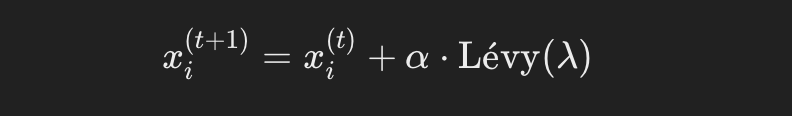
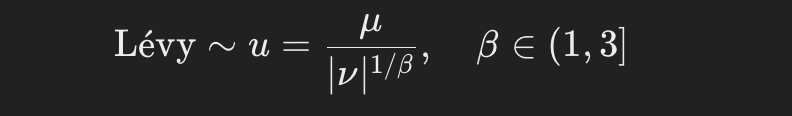

### Fitness-Based Replacement
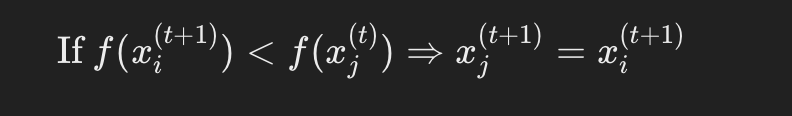

### Abandonment of Some Nests
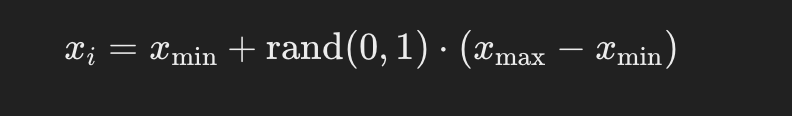

### Boundary Control
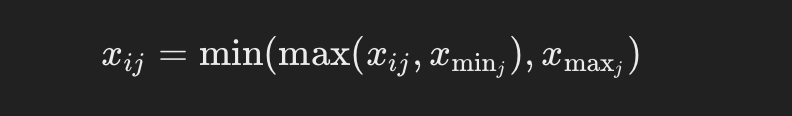

In [ ]:
def build_model(params):
    model = Sequential([
        Conv2D(params['filters1'], (3, 3), activation='relu', input_shape=(256, 256, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(params['filters2'], (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(params['units1'], activation='relu'),
        Dropout(params['dropout']),
        Dense(4, activation='softmax')
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=params['lr']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def objective_function(params, X_train, y_train):
    model = build_model(params)
    history = model.fit(X_train, y_train, epochs=3, batch_size=params['batch_size'], verbose=0, validation_split=0.1)
    val_acc = max(history.history['val_accuracy'])

    print(f"Evaluated Params: {params}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print("Memory usage (MB):", psutil.Process().memory_info().rss / 1024 ** 2)

    del history
    del model
    K.clear_session()
    gc.collect()

    return -val_acc

def load_init_params():
    with open("initial_params.json", "r") as file:
        data = json.load(file)
    
    return data

class CuckooSearchOptimization:
    def __init__(self, X_train, y_train, nests, num_nests=3, num_iterations=4, pa=0.25):
        self.X_train = X_train
        self.y_train = y_train
        self.num_nests = num_nests
        self.num_iterations = num_iterations
        self.pa = pa  # discovery probability
        self.param_space = {
            'lr': [0.0001, 0.01],
            'batch_size': [16, 64],
            'filters1': [32, 64],
            'filters2': [32, 64],
            'units1': [32, 64],
            'dropout': [0.1, 0.5],
        }
        # self.nests = [self.random_params() for _ in range(num_nests)]
        self.nests = nests
        print(self.nests)
        self.fitness = np.array([objective_function(p, X_train, y_train) for p in self.nests])

    def random_params(self):
        return {
            'lr': np.random.uniform(*self.param_space['lr']),
            'batch_size': int(np.random.uniform(*self.param_space['batch_size'])),
            'filters1': int(np.random.uniform(*self.param_space['filters1'])),
            'filters2': int(np.random.uniform(*self.param_space['filters2'])),
            'units1': int(np.random.uniform(*self.param_space['units1'])),
            'dropout': np.random.uniform(*self.param_space['dropout']),
        }

    def levy_flight(self, params):
        new_params = params.copy()
        for key in new_params:
            step = np.random.normal(0, 0.1)  # small step
            if key in ['filters1', 'filters2', 'units1', 'batch_size']:
                new_params[key] = int(np.clip(new_params[key] + step * 10, *self.param_space[key]))
            else:
                new_params[key] = np.clip(new_params[key] + step, *self.param_space[key])
        return new_params

    def optimize(self):
        for iter_num in range(self.num_iterations):
            print(f"\nIteration {iter_num + 1}/{self.num_iterations}")
            for i in range(self.num_nests):
                new_params = self.levy_flight(self.nests[i])
                new_fitness = objective_function(new_params, self.X_train, self.y_train)
                if new_fitness > self.fitness[i]:
                    print(f"Nest {i} improved.")
                    self.nests[i] = new_params
                    self.fitness[i] = new_fitness

            # Discovery and randomization
            for i in range(self.num_nests):
                if np.random.rand() < self.pa:
                    self.nests[i] = self.random_params()
                    self.fitness[i] = objective_function(self.nests[i], self.X_train, self.y_train)

            best_iter_idx = np.argmin(self.fitness)
            print(f"Best so far: Accuracy = {-self.fitness[best_iter_idx]:.4f}")

        best_index = np.argmin(self.fitness)
        return self.nests[best_index], -self.fitness[best_index]

# Run Cuckoo Search Optimization
nests = load_init_params()
cso = CuckooSearchOptimization(X_train, y_train, nests)
best_params, best_accuracy = cso.optimize()
print("\n Best Hyperparameters:", best_params)
print("Best Validation Accuracy:", best_accuracy)

[{'lr': 0.008789098700666468, 'batch_size': 22, 'filters1': 52, 'filters2': 48, 'units1': 45, 'dropout': 0.23562910689945527}, {'lr': 0.007011921512008315, 'batch_size': 26, 'filters1': 47, 'filters2': 54, 'units1': 48, 'dropout': 0.39452114202640026}, {'lr': 0.00984578875390895, 'batch_size': 56, 'filters1': 49, 'filters2': 51, 'units1': 52, 'dropout': 0.1523667422741935}]
Evaluated Params: {'lr': 0.008789098700666468, 'batch_size': 22, 'filters1': 52, 'filters2': 48, 'units1': 45, 'dropout': 0.23562910689945527}
Validation Accuracy: 0.2266
Memory usage (MB): 9517.28125
Evaluated Params: {'lr': 0.007011921512008315, 'batch_size': 26, 'filters1': 47, 'filters2': 54, 'units1': 48, 'dropout': 0.39452114202640026}
Validation Accuracy: 0.2266
Memory usage (MB): 9680.75
Evaluated Params: {'lr': 0.00984578875390895, 'batch_size': 56, 'filters1': 49, 'filters2': 51, 'units1': 52, 'dropout': 0.1523667422741935}
Validation Accuracy: 0.2266
Memory usage (MB): 8073.15625

Iteration 1/4
Evaluated 